In [214]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import openpyxl

In [215]:
# Open CSV file containing data on CO2 Emission (in tons) by country between 1750 - 2017
emissions_df = pd.read_csv("co2_emission.csv", parse_dates=['Year'], dtype={'Annual CO₂ emissions (tonnes )':'float'})
emissions_df.rename(columns={'Annual CO₂ emissions (tonnes )': 'Annual Emissions'}, inplace=True)
emissions_df['Year'] = [y.year for y in emissions_df['Year']]

# Since the column 'Entity' contains data for the entire World as well as each respective country, let's make a DF without the
# aggregated data, called 'countries_only'.
countries_only = emissions_df[emissions_df['Entity'] != 'World']

# Obtain the max value in the 'Annual Emissions' column.
maxx = countries_only['Annual Emissions'].max()

# Country with the greatest total annual emissions output on record
country_w_max_emissions = countries_only[['Entity', 'Year']].loc[countries_only['Annual Emissions'] == maxx]
print(country_w_max_emissions, maxx)

     Entity  Year
4484  China  2017 9838754028.0


In [216]:
# Next we're going to complete 2 different tasks. First, we'll read a CSV file into a DataFrame object- the CSV file contains
# World Population data over the past 12,000 years, from various different sources. Because the dataset contains numerous sources,
# some give different approximations for population size during any given year, therefore we're going to take the MEAN value
# for any year with multiple populations estimates. 

# The second thing we're going to do is create a subset of our earlier CO2 Emissions Dataframe, this time it will only contain
# Worldwide emissions data (The sum of all countries total emissions for each year). We'll then combine this Dataframe with our
# Population dataframe to create a single DF with the necessary information. 

# Open Population Growth File
population_growth_df = pd.read_csv("world_population_growth.csv", dtype={'Year': 'int'})
population_growth_df.rename(columns={"World Population over 12000 years (various sources (2019))": "World Population"}, inplace=True)

# Drop unwanted columns
population_growth_df.drop(columns=['Entity', 'Code'], inplace=True)

# Create a copy of the co2 emissions dataframe that contains ONLY Worldwide data
world_emissions = emissions_df[emissions_df['Entity'] == 'World'].copy()
world_emissions.reset_index(drop=True, inplace=True)

merged_years = world_emissions.merge(population_growth_df, on='Year', how='left')
# This isn't too useful because we get added data.
# merged_years.to_excel("Merged_population.xlsx")

# Create a list containing all the years of worldwide co2 emission data
years_to_find = [int(y) for y in world_emissions['Year']]

# Locate which of those years we have population data on.
years_with_data = population_growth_df[population_growth_df['Year'].isin(years_to_find)]
years_with_data.reset_index(drop=True, inplace=True)

# Sort the Population data in chronological order (oldest to newest)
years_with_data = years_with_data.sort_values(by=['Year'])

# Since the dataset contained duplicate years (different sources), use the mean() of the reported populations for the given year.
years_grouped = years_with_data.groupby(['Year']).mean()

# This time, let's try merging on the index instead.
world_emissions = world_emissions.merge(years_grouped, left_on='Year', how='left', right_index=True)
world_emissions.reset_index(drop=True, inplace=True)
world_emissions["World Population"] = world_emissions["World Population"].fillna(0)

# Print first 10 rows of new DataFrame
print(world_emissions.head(10))

  Entity      Code  Year  Annual Emissions  World Population
0  World  OWID_WRL  1751         9350528.0               0.0
1  World  OWID_WRL  1752         9354192.0               0.0
2  World  OWID_WRL  1753         9354192.0               0.0
3  World  OWID_WRL  1754         9357856.0               0.0
4  World  OWID_WRL  1755         9361520.0               0.0
5  World  OWID_WRL  1756        10006384.0               0.0
6  World  OWID_WRL  1757        10010048.0               0.0
7  World  OWID_WRL  1758        10013712.0               0.0
8  World  OWID_WRL  1759        10017376.0               0.0
9  World  OWID_WRL  1760        10017376.0               0.0


In [257]:
# Next we'll add a column for YoY % change for both the population and emissions columns.

# Get YoY % change for annual emissions column
pct_change = world_emissions['Annual Emissions'].pct_change()

# Create new DataFrame called 'YoY Emissions Delta'
world_emissions['YoY Emissions Delta'] = pct_change
world_emissions['YoY Emissions Delta'] = world_emissions['YoY Emissions Delta'].replace(np.nan, 0.0)

# Get % change for population in years that we have data
pct_change2 = world_emissions['World Population'].pct_change()

# Create new DataFrame called 'YoY Population Delta'
world_emissions['YoY Population Delta'] = pct_change2

# Replace missing data with Zeros
world_emissions['YoY Population Delta'] = world_emissions['YoY Population Delta'].replace(np.nan, 0)
world_emissions['YoY Population Delta'] = world_emissions['YoY Population Delta'].replace(np.inf, 0)

# Convert decimals to % value
world_emissions['YoY Emissions Delta'] = [x*100 for x in world_emissions['YoY Emissions Delta']]
world_emissions['YoY Population Delta'] = [x*100 for x in world_emissions['YoY Population Delta']]

# Find greatest % change in population growth and emissions
max_pct_change = world_emissions['YoY Population Delta'].loc[world_emissions['YoY Population Delta'] > 0].max()
max_pct_change_emissions = world_emissions['YoY Emissions Delta'].max()

# Find the year max % change in population growth ocurred.
value = world_emissions['Year'].loc[world_emissions['YoY Population Delta'] == max_pct_change]
year_of_max = value.values[0]

# Find the year the max % change in co2 emissions ocurred.
value = world_emissions['Year'].loc[world_emissions['YoY Emissions Delta'] == max_pct_change_emissions]
year_of_max_emissions = value.values[0]

# Find mean % change in annual emissions
avg_pct_change = world_emissions['YoY Population Delta'].loc[world_emissions['YoY Population Delta'] > 0].mean()

# Find mean % change in annual emissions
avg_pct_change_emissions = world_emissions['YoY Emissions Delta'].loc[world_emissions['YoY Emissions Delta'] > 0].mean()

# Print Data
print("AVG % Change in World Population since 1900: " + str(round(avg_pct_change, 2)) + "%", '\n')
print("Greatest % Change in World Population since 1900: " + str(round(max_pct_change, 2)) + "%" + " in the year " + str(year_of_max), '\n')
print("Greatest % Change in Annual Emissions output since 1751: " + str(round(max_pct_change_emissions, 2)) + "%" + " in the year " + str(year_of_max_emissions), '\n')
print("AVG % Change in World Annual Emissions since 1751: " + str(round(avg_pct_change_emissions, 2)) + "%", '\n')

AVG % Change in World Population since 1900: 1.35% 

Greatest % Change in World Population since 1900: 3.48% in the year 1951 

Greatest % Change in Annual Emissions output since 1751: 34.23% in the year 1830 

AVG % Change in World Annual Emissions since 1751: 4.45% 



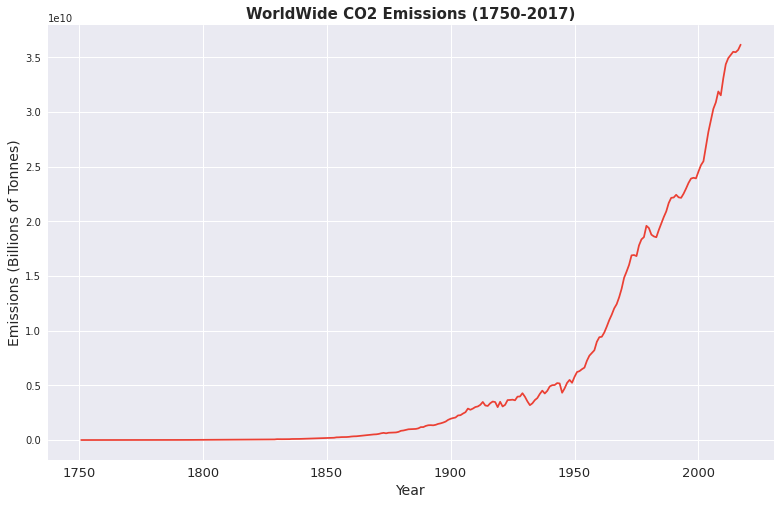

In [218]:
# Plot Worldwide Annual co2 Emissions from 1750 through 2017

# Reset index to be in order. (0,1,2...)
world_emissions.reset_index(drop=True, inplace=True)

# Create figure and style to use.
plt.style.use('seaborn')
plt.figure(figsize=(13,8))

# Set Figure Title and Axis Labels
plt.title('WorldWide CO2 Emissions (1750-2017)', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.xlabel("Year", fontdict={'fontsize':14})
plt.ylabel("Emissions (Billions of Tonnes)", fontdict={'fontsize':14})
plt.xticks(fontsize=13)

# Plot data and show
plt.plot(world_emissions['Year'], world_emissions['Annual Emissions'], color='#eb4034')
plt.show()

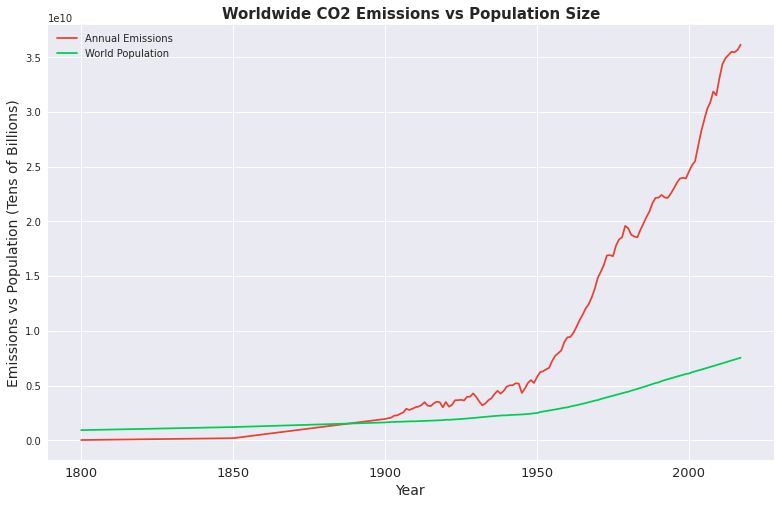

In [219]:
# Next we'll create a new DataFrame that contains only the years which have BOTH Co2 Emission and Population data. 

# Find DF rows where we have data for both the Population and Emissions output.
co2_w_pop = world_emissions[world_emissions['World Population'] > 0]

# Create Figure
plt.figure(figsize=(13,8))

# Set Title and Axis Labels
plt.title('Worldwide CO2 Emissions vs Population Size', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.xlabel("Year", fontdict={'fontsize':14})
plt.ylabel("Emissions vs Population (Tens of Billions)", fontdict={'fontsize':14})
plt.xticks(fontsize=13)

# Plot Data
plt.plot(co2_w_pop['Year'], co2_w_pop['Annual Emissions'], color='#eb4034')
plt.plot(co2_w_pop['Year'], co2_w_pop['World Population'], color='#00cc58')

# Set Figure legend.
plt.legend(['Annual Emissions', 'World Population'])
plt.show()

In [220]:
# Find year with greatest percent change in Annual Co2 emissions

# Get the Year where the maximum % change ocurred.
year = world_emissions['Year'].loc[world_emissions['YoY Emissions Delta'] == world_emissions['YoY Emissions Delta'].max()]
greatest_year = year.values[0] # 1830

# Print output
print("The year " + str(greatest_year) + " saw the greatest increase in CO2 Emissions with a " + 
        str(round(world_emissions['YoY Emissions Delta'].max(), 2)) + "%" + " increase since the year prior.")

The year 1830 saw the greatest increase in CO2 Emissions with a 34.23% increase since the year prior.


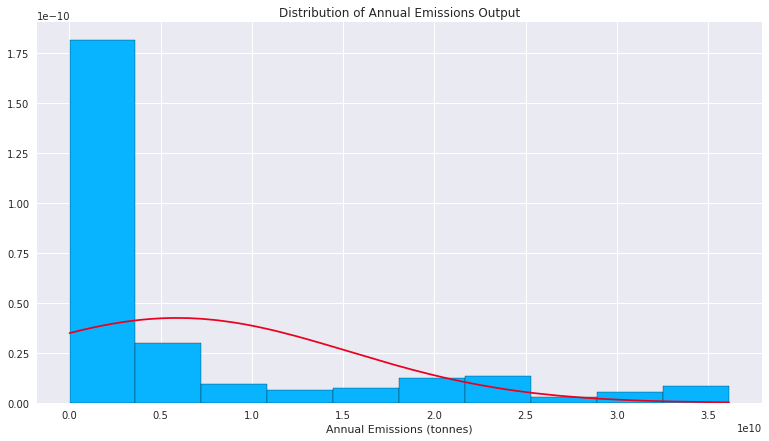

In [258]:
# Normal Distribution
plt.figure(figsize=(13,7))

plt.title("Distribution of Annual Emissions Output")

# Create x axis for figure
x_axis = sorted(world_emissions['Annual Emissions'].values)

# Create Histogram
plt.hist(world_emissions['Annual Emissions'], color='#08b4ff', edgecolor='black', density=True)

# Get Mean of column
mean = world_emissions['Annual Emissions'].mean()

# Get Standard Deviation of column
std = world_emissions['Annual Emissions'].std()

# Add labels and Title
plt.xlabel("Annual Emissions (tonnes)")

# Add line and plot
plt.plot(x_axis, norm.pdf(x_axis, mean, std), color='#eb001f')
plt.show()

In [222]:
# Collect Emissions in the United States since 1900 because China does have any emissions
# data prior to 1900
usa = emissions_df[emissions_df['Entity'] == 'United States']
usa = usa[usa['Annual Emissions'] > 0]
usa = usa[usa['Year'] >= 1900]

# Gather Chinese annual CO2 emissions
china = emissions_df[emissions_df['Entity'] == 'China']
china = china[china['Annual Emissions'] > 0]

# Find year with Maximum Co2 emissions in the USA
year_of_max = usa['Year'].loc[usa['Annual Emissions'] == usa['Annual Emissions'].max()]
print(year_of_max)

19915    2005
Name: Year, dtype: int64


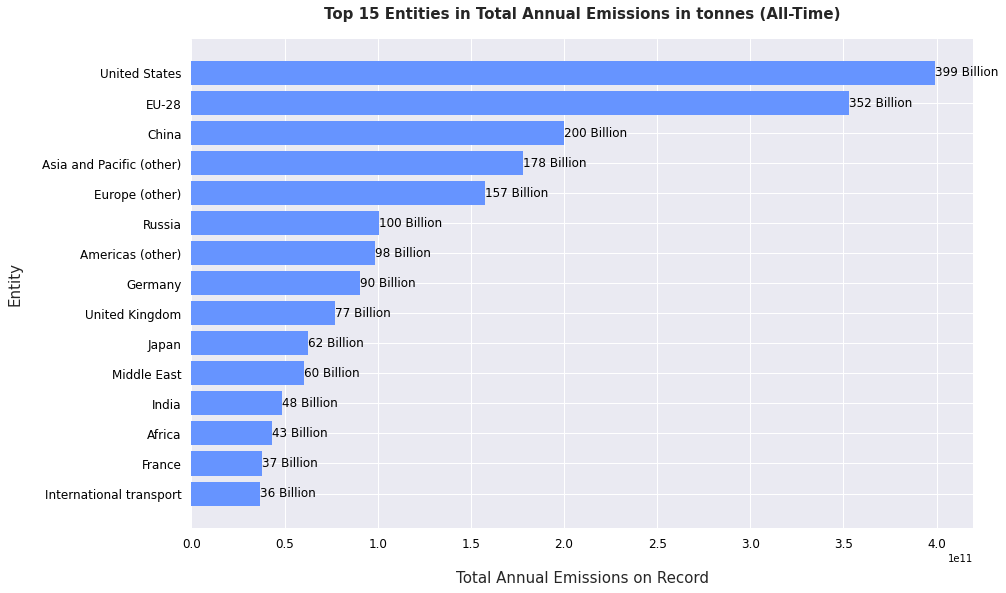

In [259]:
# Find 10 largest entities by total emissions output on record.

# Create a copy of the emissions_df DataFrame so that we can make some minor alterations.
temp_emissions_df = emissions_df.copy()

# Set the 'Year' column as type string
temp_emissions_df['Year'] = temp_emissions_df['Year'].astype('string')
grouped_by_entity = temp_emissions_df.groupby(by=['Entity'], as_index=False).sum()
grouped_by_entity = grouped_by_entity.sort_values(by=['Annual Emissions'], ascending=False)
grouped_by_entity.reset_index(drop=True, inplace=True)

# Get DF with only the Top 10 Entities, we'll start from position 1, instead of 0 because the Entity 'World' is included
# and we don't want that value since it is the sum of all the other entities. 
top_10_total_emissions = grouped_by_entity[1:16]
top_10_total_emissions.to_excel("Top 10 Entities.xlsx")

# Create Figure
fig, ax = plt.subplots(figsize=(14, 9))
plt.style.use('seaborn')

# Create Title and Axis Labels
ax.set_xlabel("Total Annual Emissions on Record", fontdict={'fontsize':15}, labelpad=20)
ax.set_ylabel("Entity", fontdict={'fontsize':15}, labelpad=20)
ax.set_title("Top 15 Entities in Total Annual Emissions in tonnes (All-Time)", fontdict={'fontsize':15, 'fontweight':'bold'}, pad=20)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=10, colors='black', labelsize=12)
ax.yaxis.set_tick_params(pad=10, colors='black', labelsize=12)

# Create bar plot
ax.barh(top_10_total_emissions["Entity"], top_10_total_emissions["Annual Emissions"], color="#6694ff")

# Add annotation to bars
for i in ax.patches:
    val = str(i.get_width()).split('.')[0]
    if len(val) == 12:
        num = val[0:3] + " Billion"
    else:
        num = val[0:2] + " Billion"
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             num,
             fontsize=12,
             color='black')

# Invert y-axis to show greatest value at top. 
ax.invert_yaxis()
plt.show()


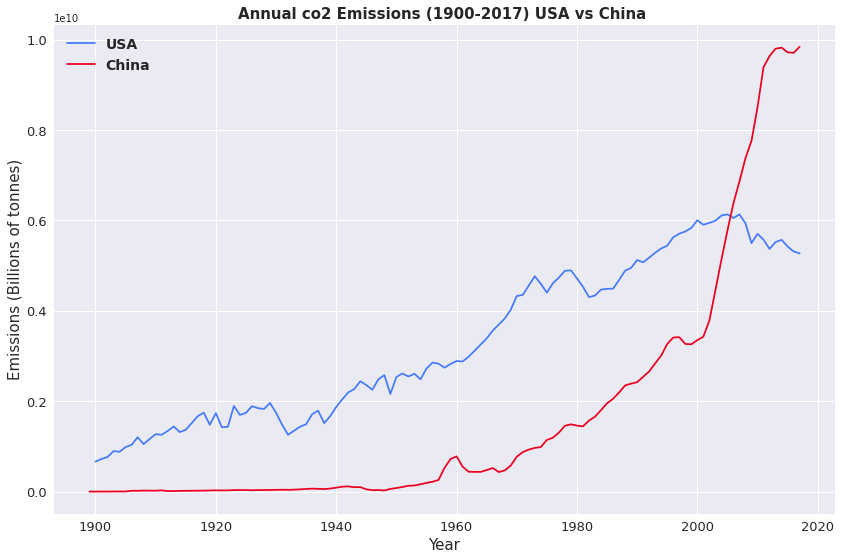

In [224]:
# Plot USA and China Data
plt.figure(figsize=(14,9))

# Add Title, and Axis Labels
plt.title('Annual co2 Emissions (1900-2017) USA vs China ', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.xlabel("Year", fontdict={'fontsize':15})
plt.ylabel("Emissions (Billions of tonnes)", fontdict={'fontsize':15})

# Change font size of xticks
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Plot Data
plt.plot(usa['Year'], usa['Annual Emissions'], color='#457aff')
plt.plot(china["Year"], china['Annual Emissions'], color='#eb001f')
plt.legend(["USA", "China"], prop={"size":14, "weight":"bold"})

plt.show()